# WAMIDA Statistical Analysis

## Author: Ricky Hu

This Jupyter notebook displays the statistical processing of the WAMIDA data. Note that the imported data is only available locally on a host machine and this code will not run without the exact same filename accessible by this notebook

## Method:

Analysis has 3 components

**1. Data Prepocessing and Cleaning**

Data is cleaned, with irrelevant data removed, including analysis of Variance Inflation Factor for colinearity and a confusion matrix to highlight low variance variables

**2. Statistical Significance**

T, Wilcoxon, and Fisher tests are performed to analyze statistical significance of data because biostats loves p values.

**3. Logistic Regression**

The remaining significant data is placed into a logistic regression model using a maximum likelihood estimate algorithm. The odds ratio of each variable is reported.

In [2]:
# Setup, imports

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from patsy import dmatrices
import statsmodels.api as sm 
import seaborn as sn

In [3]:
data_num = pd.read_excel('data_numerical.xlsx')
data_cat = pd.read_excel('data_categorical.xlsx')
data = pd.read_excel('data.xlsx')
print(data_num.shape)
data_num

(60, 25)


,Age,People in House,Rooms in House,Rooms per Person,Pack Years,Drinks/Week,Pre-COVID Anxiety about Health,Post-COVID Anxiety about Health,Height,Weight,...,Hx Anxiety,Time to Care Impacted by COVID?,COVID Lonely?,Stroke,Previous AMI,Previous Stent/CABG,High Cholesterol,Diabetes,Bin Anx,Bin Dep
0,78,1,1,1.000000,17,0,1,1,60,125.00,...,0,1,0,0,0,0,0,0,1,1
1,67,1,2,2.000000,26,10,0,0,71,140.00,...,0,0,0,0,1,1,0,0,0,0
2,80,2,2,1.000000,30,25,0,1,73,170.72,...,0,0,0,0,0,0,0,0,0,0
3,56,2,3,1.500000,40,0,0,0,76,200.00,...,0,0,0,0,0,0,1,0,0,0
4,58,2,3,1.500000,40,0,1,3,61,140.00,...,1,0,0,0,0,0,1,0,1,0
5,82,2,3,1.500000,2,0,1,1,72,184.00,...,0,0,0,0,1,0,0,0,0,1
6,75,5,5,1.000000,20,14,2,3,72,200.00,...,0,0,0,1,0,0,0,0,0,1
7,73,3,4,1.333333,0,5,3,3,61,165.00,...,0,1,1,0,0,0,1,0,1,0
8,67,2,3,1.500000,0,3,1,1,67,157.00,...,1,0,0,0,0,0,0,0,1,0
9,55,1,2,2.000000,14,0,2,3,72,213.40,...,0,0,1,0,1,0,1,1,0,0


## Sample Visualization

Text(0, 0.5, 'Frequency')

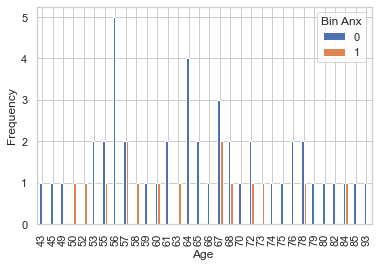

In [4]:
%matplotlib inline
pd.crosstab(data_num['Age '],data_num['Bin Anx']).plot(kind='bar')
plt.xlabel('Age ')
plt.ylabel('Frequency')

In [5]:
data_num.columns

Index(['Age ', 'People in House', 'Rooms in House', 'Rooms per Person',
       'Pack Years', 'Drinks/Week', 'Pre-COVID Anxiety about Health',
       'Post-COVID Anxiety about Health', 'Height', 'Weight', 'BMI', 'HADS D',
       'HADS A', 'Hx Substance Use Disorder', 'Hx Depression', 'Hx Anxiety ',
       'Time to Care Impacted by COVID?', 'COVID Lonely?', 'Stroke',
       'Previous AMI', 'Previous Stent/CABG', 'High Cholesterol', 'Diabetes',
       'Bin Anx', 'Bin Dep'],
      dtype='object')

Testing Colinearity with Vairance Inflation Factor

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)


In [7]:
X = data_num.iloc[:,:]
calc_vif(X)

,variables,VIF
0,Age,107.957160
1,People in House,27.894113
2,Rooms in House,40.251102
3,Rooms per Person,23.304069
4,Pack Years,4.195928
5,Drinks/Week,1.911135
6,Pre-COVID Anxiety about Health,4.634573
7,Post-COVID Anxiety about Health,7.525983
8,Height,264.463968
9,Weight,249.353205


As expected, the HADS A and HADS D scores is colinear (with the binary axiety and depression measure). We can then remove the colinear variables.

We can visualize correlation with a correlation matrix

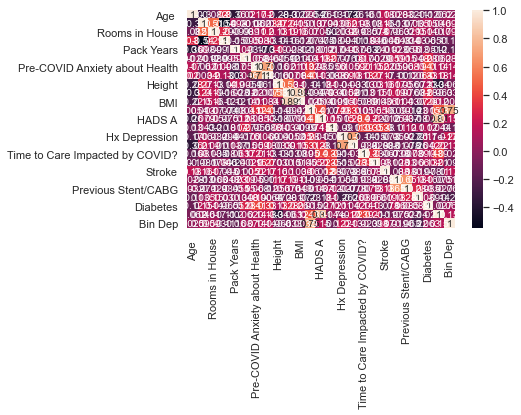

In [8]:
corrMatrix = data_num.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can revisualize again with the colinear features removed

In [9]:
data_num2 = data_num.drop(columns = ['People in House', 'Rooms in House', 'Rooms per Person', 'Height', 'Weight', 'HADS D', 'HADS A'])

,Age,Pack Years,Drinks/Week,Pre-COVID Anxiety about Health,Post-COVID Anxiety about Health,BMI,Hx Substance Use Disorder,Hx Depression,Hx Anxiety,Time to Care Impacted by COVID?,COVID Lonely?,Stroke,Previous AMI,Previous Stent/CABG,High Cholesterol,Diabetes,Bin Anx,Bin Dep
0,78,17,0,1,1,24.409722,0,0,0,1,0,0,0,0,0,0,1,1
1,67,26,10,0,0,19.523904,0,0,0,0,0,0,1,1,0,0,0,0
2,80,30,25,0,1,22.521329,0,0,0,0,0,0,0,0,0,0,0,0
3,56,40,0,0,0,24.342105,0,0,0,0,0,0,0,0,1,0,0,0
4,58,40,0,1,3,26.449879,0,0,1,0,0,0,0,0,1,0,1,0
5,82,2,0,1,1,24.952160,0,0,0,0,0,0,1,0,0,0,0,1
6,75,20,14,2,3,27.121914,0,0,0,0,0,1,0,0,0,0,0,1
7,73,0,5,3,3,31.173072,0,0,0,1,1,0,0,0,1,0,1,0
8,67,0,3,1,1,24.586990,0,1,1,0,0,0,0,0,0,0,1,0
9,55,14,0,2,3,28.939082,0,0,0,0,1,0,1,0,1,1,0,0


## Sample visualization of the correlation matrix of only the numerical data (this won't really work for the categorical data)

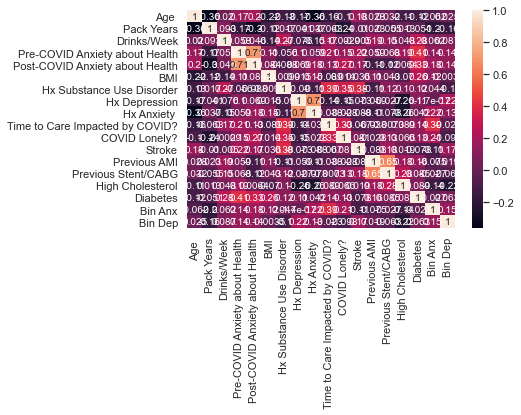

In [10]:
corrMatrix2 = data_num2.corr()
sn.heatmap(corrMatrix2, annot=True)
plt.show()

For the nominal cateogrical variables we have to use a chi-square test (this was really annoying haha)

In [11]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))



In [12]:
cat_vars = ['Sex', 'Education Level', 'Employment', 'Income (2019)', 'Married', 'House Situation', 'Ethnicity']
data2 = data
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data2=data2.join(cat_list)

data3 = data2.drop(columns=cat_vars)
data3 = data3.drop(columns=['Study ID'])

In [13]:
X = data3.iloc[:,:]
calc_vif(X)

c:\users\ricky hu\appdata\local\programs\python\python36\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,Age,9.005246
1,People in House,18.956736
2,Rooms in House,11.830614
3,Rooms per Person,10.980041
4,Pack Years,4.541010
5,Drinks/Week,3.284267
6,Pre-COVID Anxiety about Health,6.396261
7,Post-COVID Anxiety about Health,11.195637
8,Height,121.608810
9,Weight,472.827175


## Removing colinear variables

In [14]:
data_final = data3.drop(columns=['People in House', 'Rooms in House', 'Rooms per Person', 'Height', 'Weight','HADS D','HADS A' ])
X2 = data_final.iloc[:,:]
calc_vif(X2)

c:\users\ricky hu\appdata\local\programs\python\python36\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,Age,5.610429
1,Pack Years,3.762673
2,Drinks/Week,2.148983
3,Pre-COVID Anxiety about Health,5.846188
4,Post-COVID Anxiety about Health,5.532065
5,BMI,2.918839
6,Hx Substance Use Disorder,4.458632
7,Hx Depression,7.450061
8,Hx Anxiety,7.648201
9,Time to Care Impacted by COVID?,5.960127


## Removing low-variance variables

In [44]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# min_variance = .9 * (1 - .9)  # You can play here with different values.
X = data_final.drop(columns = ['Bin Anx', 'Bin Dep'])
min_variance = 0.1
high_var_cols = variance_threshold_selector(X, min_variance) 
print('columns remaining: ', high_var_cols.columns )
print(len(high_var_cols.columns))
X_low_var_removed = data_final[high_var_cols.columns]
X_low_var_removed

columns remaining:  Index(['Age', 'Pack Years', 'Drinks/Week', 'Pre-COVID Anxiety about Health',
       'Post-COVID Anxiety about Health', 'BMI', 'Hx Depression',
       'Hx Anxiety ', 'Time to Care Impacted by COVID?', 'COVID Lonely?',
       'Previous AMI', 'Previous Stent/CABG', 'High Cholesterol', 'Diabetes',
       'Sex_F', 'Sex_M', 'Education Level_College',
       'Education Level_Highschool', 'Education Level_Less than Highschool',
       'Employment_Full-time', 'Employment_Retired', 'Employment_Unemployed ',
       'Income (2019)_100-149k', 'Income (2019)_150k+', 'Income (2019)_20-49k',
       'Income (2019)_50-99k', 'Married_Divorced', 'Married_Married',
       'Married_Widowed', 'House Situation_Own', 'House Situation_Rent'],
      dtype='object')
31


,Age,Pack Years,Drinks/Week,Pre-COVID Anxiety about Health,Post-COVID Anxiety about Health,BMI,Hx Depression,Hx Anxiety,Time to Care Impacted by COVID?,COVID Lonely?,...,Employment_Unemployed,Income (2019)_100-149k,Income (2019)_150k+,Income (2019)_20-49k,Income (2019)_50-99k,Married_Divorced,Married_Married,Married_Widowed,House Situation_Own,House Situation_Rent
0,78,17,0,1,1,24.409722,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
1,67,26,10,0,0,19.523904,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
2,80,30,25,0,1,22.521329,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3,56,40,0,0,0,24.342105,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
4,58,40,0,1,3,26.449879,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
5,82,2,0,1,1,24.952160,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
6,75,20,14,2,3,27.121914,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
7,73,0,5,3,3,31.173072,0,0,1,1,...,0,0,0,1,0,0,1,0,1,0
8,67,0,3,1,1,24.586990,1,1,0,0,...,0,1,0,0,0,0,1,0,1,0
9,55,14,0,2,3,28.939082,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1


## Observing correlation values between variables

In [61]:
corrs = X.corr()
corrs.to_csv('corr.csv')
print(corrs.columns)

Index(['Age', 'Pack Years', 'Drinks/Week', 'Pre-COVID Anxiety about Health',
       'Post-COVID Anxiety about Health', 'BMI', 'Hx Substance Use Disorder',
       'Hx Depression', 'Hx Anxiety ', 'Time to Care Impacted by COVID?',
       'COVID Lonely?', 'Stroke', 'Previous AMI', 'Previous Stent/CABG',
       'High Cholesterol', 'Diabetes', 'Sex_F', 'Sex_M',
       'Education Level_College', 'Education Level_Graduate ',
       'Education Level_Highschool', 'Education Level_Less than Highschool',
       'Education Level_Tech/Vocation', 'Education Level_Undergrad',
       'Employment_Full-time', 'Employment_Part-time', 'Employment_Retired',
       'Employment_Unemployed ', 'Income (2019)_10-19k',
       'Income (2019)_100-149k', 'Income (2019)_150k+', 'Income (2019)_20-49k',
       'Income (2019)_50-99k', 'Married_Divorced', 'Married_Married',
       'Married_Never', 'Married_Separated', 'Married_Widowed',
       'House Situation_Friends/Family', 'House Situation_Own',
       'House Situat

# Now that no remaining variables are colinear, we can begin regression

In [82]:
import statsmodels.api as sm

# for Anxiety
y = data_final['Bin Anx']

# Manually removing variables that don't cause convergence
X = data_final.drop(columns = ['Bin Anx', 'Bin Dep', 'Education Level_College', 'Education Level_Graduate ',\
                               'Employment_Full-time',\
                              'Employment_Retired','Employment_Unemployed ','Married_Divorced', \
                              'Married_Never','Married_Widowed','House Situation_Friends/Family', \
                              'House Situation_Own','House Situation_Rent'])

print(X.columns)
logit_model=sm.Logit(y,X, method = 'bfgs')
result=logit_model.fit()
print(result.summary2())


Index(['Age', 'Pack Years', 'Drinks/Week', 'Pre-COVID Anxiety about Health',
       'Post-COVID Anxiety about Health', 'BMI', 'Hx Substance Use Disorder',
       'Hx Depression', 'Hx Anxiety ', 'Time to Care Impacted by COVID?',
       'COVID Lonely?', 'Stroke', 'Previous AMI', 'Previous Stent/CABG',
       'High Cholesterol', 'Diabetes', 'Sex_F', 'Sex_M',
       'Education Level_Highschool', 'Education Level_Less than Highschool',
       'Education Level_Tech/Vocation', 'Education Level_Undergrad',
       'Employment_Part-time', 'Income (2019)_10-19k',
       'Income (2019)_100-149k', 'Income (2019)_150k+', 'Income (2019)_20-49k',
       'Income (2019)_50-99k', 'Married_Married', 'Married_Separated',
       'Ethnicity_Caucasian', 'Ethnicity_Indigenous'],
      dtype='object')
         Current function value: 0.188341
         Iterations: 35
                                             Results: Logit
Model:                            Logit                          Pseudo R-squared:    

c:\users\ricky hu\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Removing low correlation variables

In [83]:
X2 = X.drop(columns=['Income (2019)_10-19k', 'Income (2019)_100-149k', 'Income (2019)_150k+','Income (2019)_20-49k', 'Income (2019)_50-99k',\
                    'Ethnicity_Caucasian', 'Ethnicity_Indigenous'])
print(X2.columns)
logit_model=sm.Logit(y,X2, method = 'bfgs')
result=logit_model.fit()
print(result.summary2())


Index(['Age', 'Pack Years', 'Drinks/Week', 'Pre-COVID Anxiety about Health',
       'Post-COVID Anxiety about Health', 'BMI', 'Hx Substance Use Disorder',
       'Hx Depression', 'Hx Anxiety ', 'Time to Care Impacted by COVID?',
       'COVID Lonely?', 'Stroke', 'Previous AMI', 'Previous Stent/CABG',
       'High Cholesterol', 'Diabetes', 'Sex_F', 'Sex_M',
       'Education Level_Highschool', 'Education Level_Less than Highschool',
       'Education Level_Tech/Vocation', 'Education Level_Undergrad',
       'Employment_Part-time', 'Married_Married', 'Married_Separated'],
      dtype='object')
         Current function value: 0.282962
         Iterations: 35
                                                             Results: Logit
Model:                                       Logit                                    Pseudo R-squared:                         0.497   
Dependent Variable:                          Bin Anx                                  AIC:                                

c:\users\ricky hu\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
